# <b>AASD 4011 - Mathematical Concepts for Deep Learning Group Project</b>

### <b>Group Name:</b> Team Team Team
### <b>Member:</b> 1. Zifeng Chen (101411338)  2. Siu Fung Chan (101427740)

The goal of this project is to explore the potential of deep learning in predicting the direction of Bitcoin's price. Our aim is to use Long Short-Term Memory (LSTM), a type of recurrent neural network, to analyze historical price data of Bitcoin in USD. The objective is to provide a more stable and robust model compared to directly predicting the price itself. To increase the accuracy of our model, we will incorporate the Rolling Mean of Momentum as a feature and optimize the model through hyper-parameter tuning. This feature provides information about the trend of the price and helps our model capture underlying patterns in the data, and it incorporates the concept of AR (Autoregressive) by using different lags. Our ultimate goal is to develop a model that accurately predicts the direction of Bitcoin's price, providing insights and opportunities for traders and investors. We will also compare our results with a stock prediction model built in a previous Deep Learning course to see if this data preprocessing enhances the performance of the model.

### <b>Reference:</b> https://medium.com/mlearning-ai/4-simple-steps-for-deep-learning-to-predict-price-direction-for-bitcoin-6df3e876f37b

## Load Libraries 

In [649]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Concatenate, Dropout
from keras.callbacks import ModelCheckpoint
import yfinance as yf
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

import warnings
import seaborn as sns
warnings.filterwarnings("ignore")


## Load data

In [614]:
#Getting the raw data 
ticker_symbol = "BTC-USD"
ticker_data = yf.Ticker(ticker_symbol)

#Get the historical prices for this ticker
data = ticker_data.history(interval = '1d', start = '2010-1-1', end = '2022-12-30')
data['price'] = (data['High'] + data['Low'])/2
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,price
Date,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,460.298004
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,434.981995
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,406.183502
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0,406.589493
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0,402.803497
...,...,...,...,...,...,...,...,...
2022-12-25 00:00:00+00:00,16847.505859,16860.554688,16755.253906,16841.986328,11656379938,0.0,0.0,16807.904297
2022-12-26 00:00:00+00:00,16842.250000,16920.123047,16812.369141,16919.804688,11886957804,0.0,0.0,16866.246094
2022-12-27 00:00:00+00:00,16919.291016,16959.845703,16642.072266,16717.173828,15748580239,0.0,0.0,16800.958984


Text(0, 0.5, 'Price USD')

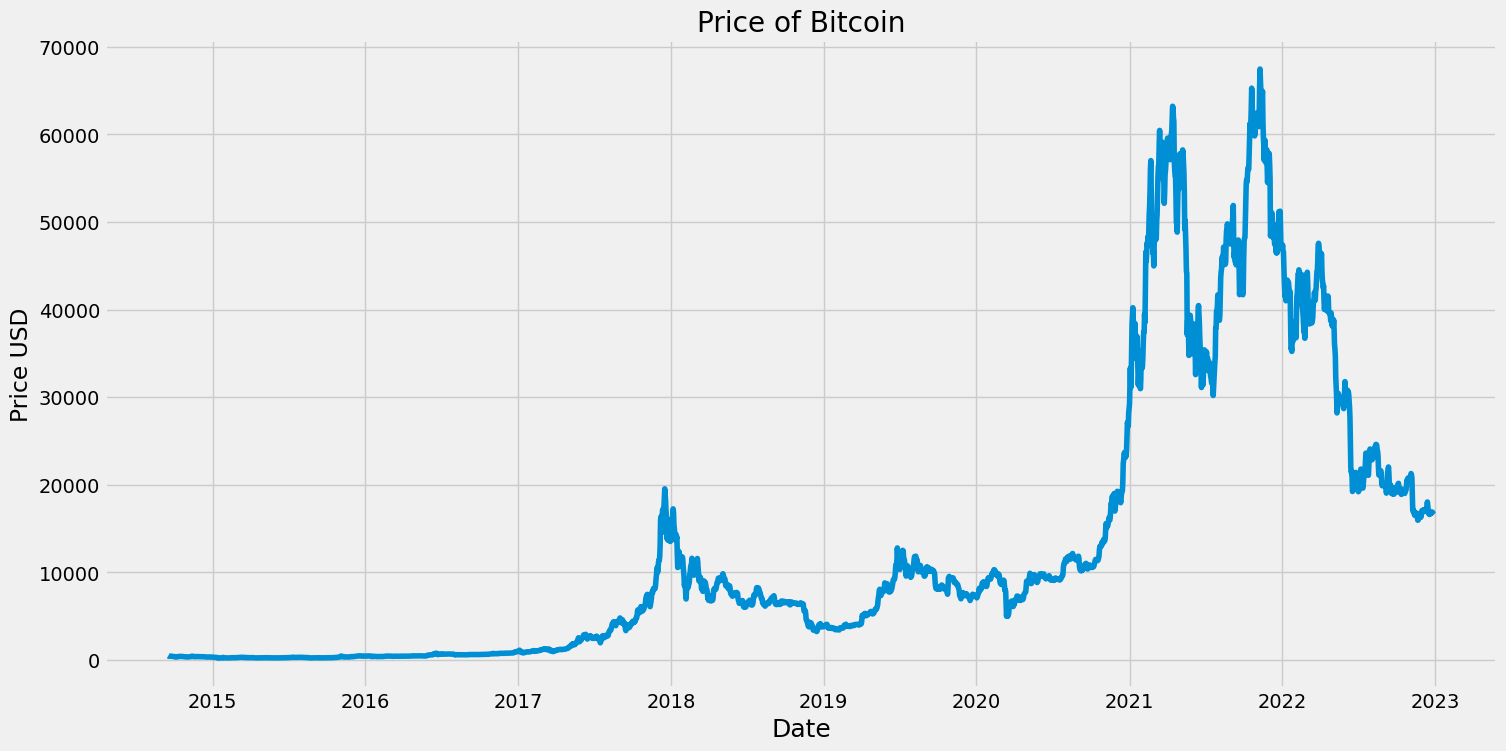

In [615]:
#Visualize the price history
plt.figure(figsize=(16,8))
plt.title('Price of Bitcoin')
plt.plot(data['price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD')

<AxesSubplot: xlabel='Date'>

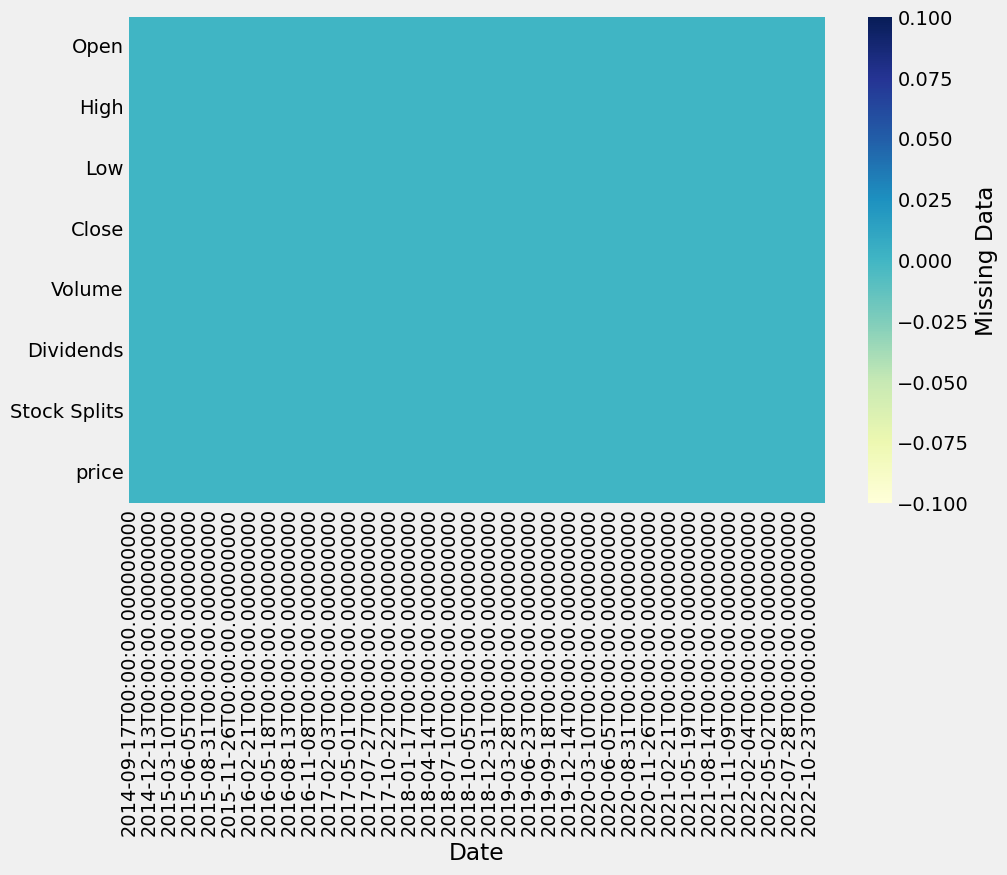

In [616]:
plt.figure(figsize=(10,6))
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
# It has no missing values in the dataset!!

## Further work on the database
- log_returns is the change on price
- momentum would be the 5 days moving average of log_returns
- violatility would be 20 days standard deviation of log_returns
- distance means the difference of price between 50 days moving average and the price of that day

In [617]:
#Create a dataframe with date and price
df = data[['price']]

#Create a column for log return to the price go up or down
df['log_returns'] = np.log(df['price'] / df['price'].shift(1))

#Return 1 if price went up that day, else 0
df['position'] = np.where(df['log_returns'] > 0,1,0)

#Creating Lag feature, and the previous depending on which lag number
#e.g lags_3 means the price 3 days ago
def lag_column_creator(df, num_lags, col, inplace):
    for lag_num in range(1, num_lags + 1):
        df[f'lags_{lag_num}'] = df[col].shift(lag_num)
        df.dropna(inplace = inplace)
    return df
df = lag_column_creator(df, 7, 'log_returns', True)

#Different indicator 
df['momentum'] = df['log_returns'].rolling(5).mean().shift(1)
df['volatility'] = df['log_returns'].rolling(20).std().shift(1)
df['distance'] = (df['price'] - df['price'].rolling(50).mean()).shift(1)

df.dropna(inplace = True)
df

,price,log_returns,position,lags_1,lags_2,lags_3,lags_4,lags_5,lags_6,lags_7,momentum,volatility,distance
Date,,,,,,,,,,,,,
2014-12-05 00:00:00+00:00,372.473999,-0.001966,0,-0.014574,-0.005962,0.002063,0.005929,-0.005160,0.024588,-0.001323,-0.003541,0.024128,5.322031
2014-12-06 00:00:00+00:00,374.696503,0.005949,1,-0.001966,-0.014574,-0.005962,0.002063,0.005929,-0.005160,0.024588,-0.002902,0.022992,4.858319
2014-12-07 00:00:00+00:00,374.783493,0.000232,1,0.005949,-0.001966,-0.014574,-0.005962,0.002063,0.005929,-0.005160,-0.002898,0.022867,7.195563
2014-12-08 00:00:00+00:00,368.957489,-0.015667,0,0.000232,0.005949,-0.001966,-0.014574,-0.005962,0.002063,0.005929,-0.003264,0.021776,7.528173
2014-12-09 00:00:00+00:00,354.008987,-0.041359,0,-0.015667,0.000232,0.005949,-0.001966,-0.014574,-0.005962,0.002063,-0.005205,0.020960,2.126979
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-25 00:00:00+00:00,16807.904297,-0.001261,0,-0.001231,0.007165,-0.006365,0.006910,0.007058,-0.009219,0.002946,0.002707,0.014722,-298.377012
2022-12-26 00:00:00+00:00,16866.246094,0.003465,1,-0.001261,-0.001231,0.007165,-0.006365,0.006910,0.007058,-0.009219,0.001044,0.014613,-230.300820
2022-12-27 00:00:00+00:00,16800.958984,-0.003878,0,0.003465,-0.001261,-0.001231,0.007165,-0.006365,0.006910,0.007058,0.000355,0.014553,-86.628262


<AxesSubplot: xlabel='Date'>

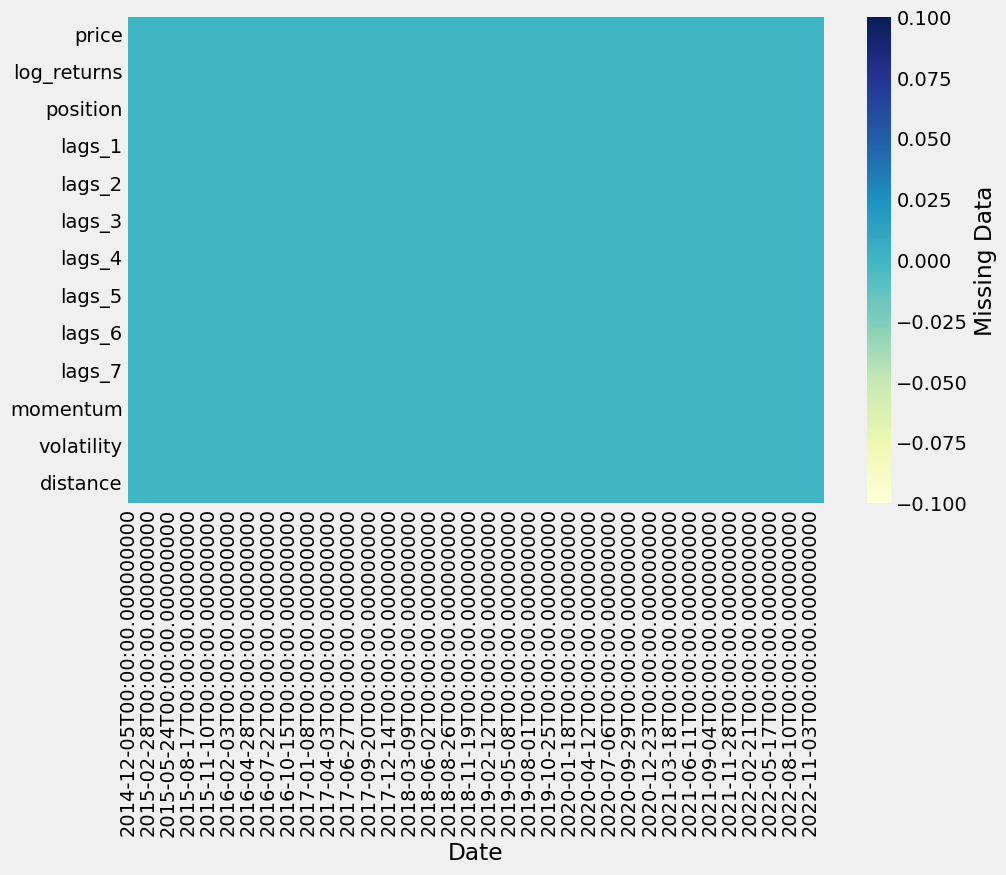

In [618]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
# It has no missing values in the dataset!!

## Cut the data

In [619]:
# Firstly, we consider about the time series of the price
column_names = list(df.columns)[2:-3]
column_names
df_7lags = df[column_names]

# Secondly, we also consider about the time series of the momentum, volatility, and distance
df_momentum = df[['momentum']]
df_momentum = lag_column_creator(df_momentum, 7, 'momentum', True)
print(df_momentum.shape)
df_volatility = df[['volatility']]
df_volatility = lag_column_creator(df_volatility, 7, 'volatility', True)
print(df_volatility.shape)
df_distance = df[['distance']]
df_distance = lag_column_creator(df_distance, 7, 'distance', True)
print(df_distance.shape)

(2919, 8)
(2919, 8)
(2919, 8)


### This function built for scaling and reshaping those 3 inputs

In [620]:
def min_max_with_reshape(df):
    df1 = df[df.index <= '2021-12-31'].copy()
    df_x = df1.iloc[:,1:]
    mean, std = df_x.mean(), df_x.std()
    df_x_value = (df_x - mean) / std
    x_train = df_x_value.values
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    df2 = df[df.index > '2021-12-31'].copy()
    df_y = df2.iloc[:,1:]
    mean, std = df_y.mean(), df_y.std()
    df_y_value = (df_y - mean) / std
    y_train = df_y_value.values
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
    return x_train, y_train


In [621]:
momentum_train, momentum_test = min_max_with_reshape(df_momentum)
print(momentum_train.shape)
volatility_train, volatility_test = min_max_with_reshape(df_volatility)
print(volatility_train.shape)
distance_train, distance_test = min_max_with_reshape(df_distance)
print(distance_train.shape)

(2556, 7, 1)
(2556, 7, 1)
(2556, 7, 1)


In [622]:
#Split training and testing data
#Training data
df_7lags_v1 = df_7lags[df_7lags.index > '2015-01-01'].copy()
training_data = df_7lags_v1[df_7lags_v1.index <= '2021-12-31'].copy()
training_data_x = training_data.iloc[:,1:]
training_data_y = training_data.iloc[:,:1]

mean, std = training_data_x.mean(), training_data_x.std()
training_data_x_value = (training_data_x - mean) / std

x_train = training_data_x_value.values
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

y_train = training_data_y.values

In [623]:
print(x_train.shape)
print(y_train.shape)

(2556, 7, 1)
(2556, 1)


In [624]:
#Split training and testing data
#Testing data
training_data = df_7lags[df_7lags.index > '2021-12-31'].copy()

testing_data_x = training_data.iloc[:,1:]
testing_data_y = training_data.iloc[:,:1]

testing_data_x_value = (testing_data_x - mean) / std

x_test = testing_data_x_value.values
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_test = testing_data_y.values

In [625]:
print(x_test.shape)
print(y_test.shape)

(363, 7, 1)
(363, 1)


## After data-preparation, it's the time to build the model!
Data list:
- target: y_train for the position 
- x_train for 7 lags of price
- momentum_train, volatility_train, distance_train

Model architecture:

A multi-input LSTM model, different branches are used to process different inputs in parallel. Each branch can have its own set of LSTM units and weights, allowing it to capture and process the information in a unique and separate way.

Using separate branches in a multi-input LSTM model allows for more nuanced and customized processing of different sources of information.

In [626]:
def multi_branch_lstm(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data, optimizer, batch_size, epoch):
    # Define the inputs for each LSTM branch
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)
    
    input2 = Input(shape=(timesteps, X_train[1].shape[-1]))
    lstm3 = LSTM(units_l1, return_sequences=True)(input2)
    lstm4 = LSTM(units_l2)(lstm3)
    
    input3 = Input(shape=(timesteps, X_train[2].shape[-1]))
    lstm5 = LSTM(units_l1, return_sequences=True)(input3)
    lstm6 = LSTM(units_l2)(lstm5)
    
    input4 = Input(shape=(timesteps, X_train[3].shape[-1]))
    lstm7 = LSTM(units_l1, return_sequences=True)(input4)
    lstm8 = LSTM(units_l2)(lstm7)

    # Concatenate the outputs from each branch
    concat = Concatenate()([lstm2, lstm4, lstm6, lstm8])
    dense1 = Dense(64, activation='relu')(concat)
    dense2 = Dense(32, activation='relu')(dense1)
    output = Dense(1, activation='relu')(dense2)

    # Define the model with multiple inputs and a single output
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    model = model.fit(x=X_train, y=y_train, validation_data=(X_val_dataset, y_val_data), batch_size=batch_size, epochs=epoch)

    return model

In [628]:
timesteps = 7
units_l1 = 64
units_l2 = 32
learning_rate = [0.005, 0.001]
batch_size = [1, 8, 16, 32]
epochs = [25]
model_pool = []

for lr in learning_rate:
    optimizers = [tf.keras.optimizers.legacy.Adam(lr), tf.keras.optimizers.legacy.Nadam(lr), tf.keras.optimizers.legacy.RMSprop(lr)]
    #optimizers = ['adam', 'SGD']
    for bs in batch_size:
        for epoch in epochs:
            for op in optimizers:
                model_pool.append(multi_branch_lstm(timesteps = timesteps, units_l1=units_l1, units_l2=units_l2
                , X_train = [x_train, momentum_train, volatility_train, distance_train]
                , y_train = y_train.flatten()
                , X_val_dataset=[x_test, momentum_test, volatility_test, distance_test]
                , y_val_data = y_test.flatten(), optimizer = op, batch_size = bs, epoch = 25))
                print(f'learning_rate:{lr}, Optimizer:{op}, batch_size:{bs}, epoch:{epoch}') 

Epoch 1/25
2556/2556 [==============================] - 16s 4ms/step - loss: 6.9070 - accuracy: 0.5454 - val_loss: 8.4018 - val_accuracy: 0.4490
Epoch 2/25
2556/2556 [==============================] - 9s 3ms/step - loss: 6.9146 - accuracy: 0.5466 - val_loss: 8.4018 - val_accuracy: 0.4490
Epoch 3/25
2556/2556 [==============================] - 10s 4ms/step - loss: 6.9146 - accuracy: 0.5466 - val_loss: 8.4018 - val_accuracy: 0.4490
Epoch 4/25
2556/2556 [==============================] - 10s 4ms/step - loss: 6.9146 - accuracy: 0.5466 - val_loss: 8.4018 - val_accuracy: 0.4490
Epoch 5/25
2556/2556 [==============================] - 10s 4ms/step - loss: 6.9146 - accuracy: 0.5466 - val_loss: 8.4018 - val_accuracy: 0.4490
Epoch 6/25
2556/2556 [==============================] - 9s 4ms/step - loss: 6.9146 - accuracy: 0.5466 - val_loss: 8.4018 - val_accuracy: 0.4490
Epoch 7/25
2556/2556 [==============================] - 10s 4ms/step - loss: 6.9146 - accuracy: 0.5466 - val_loss: 8.4018 - val_accu

## Evaluate and compare

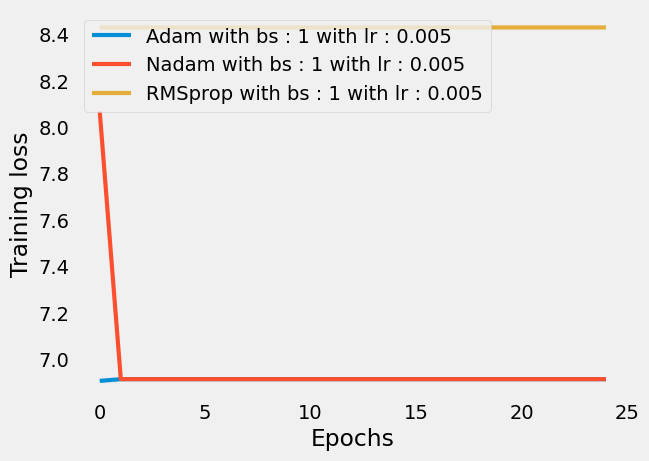

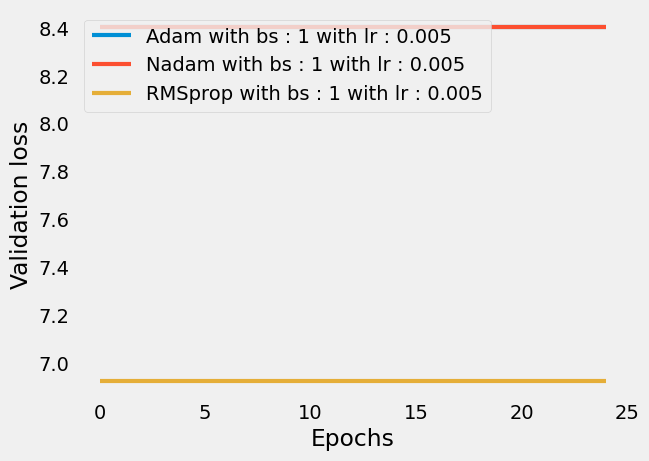

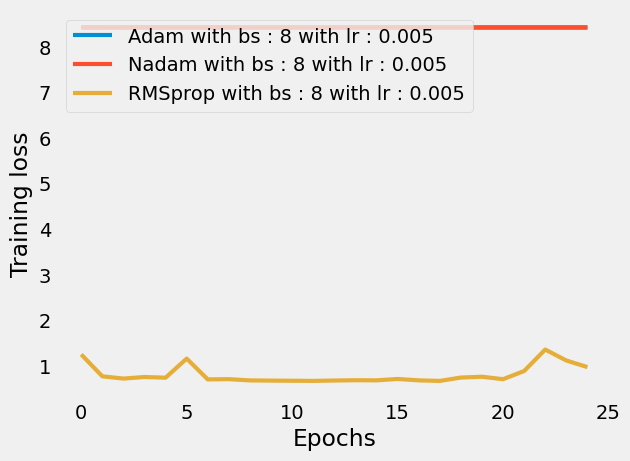

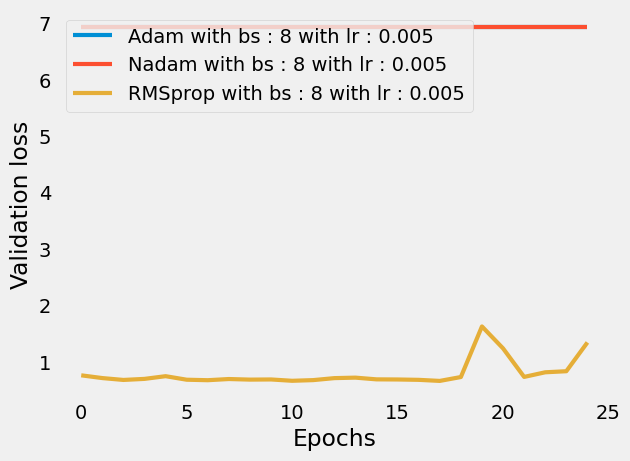

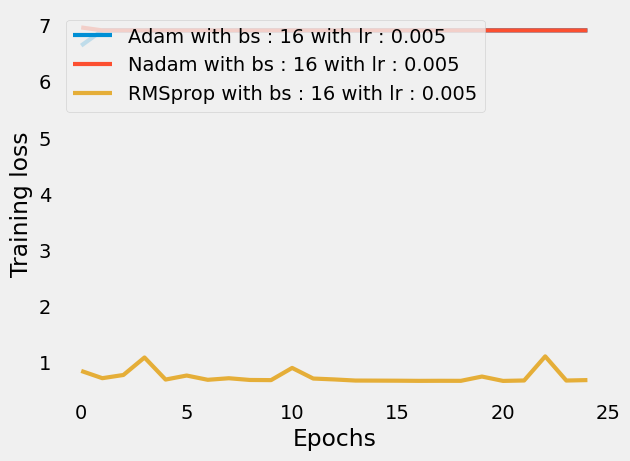

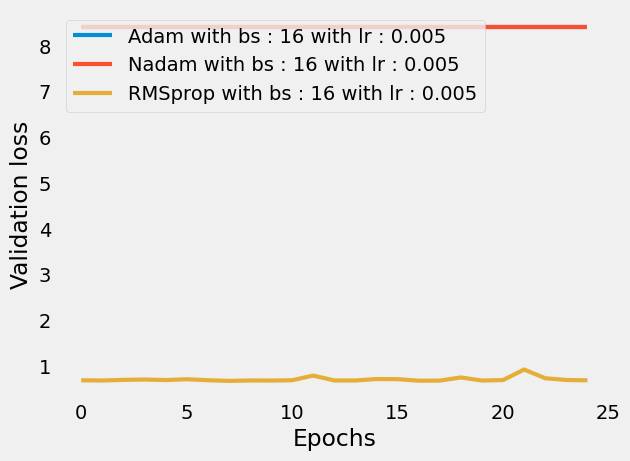

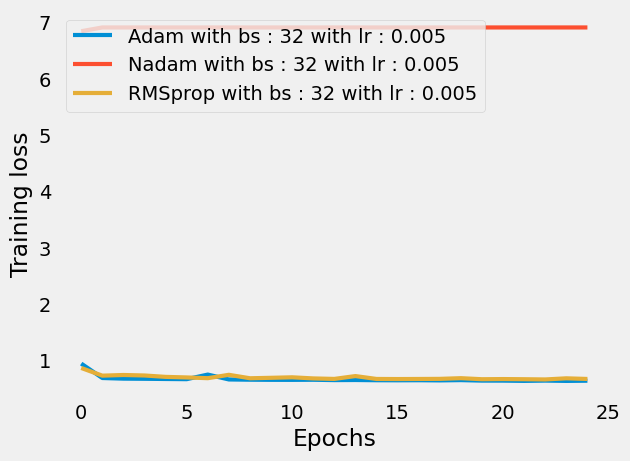

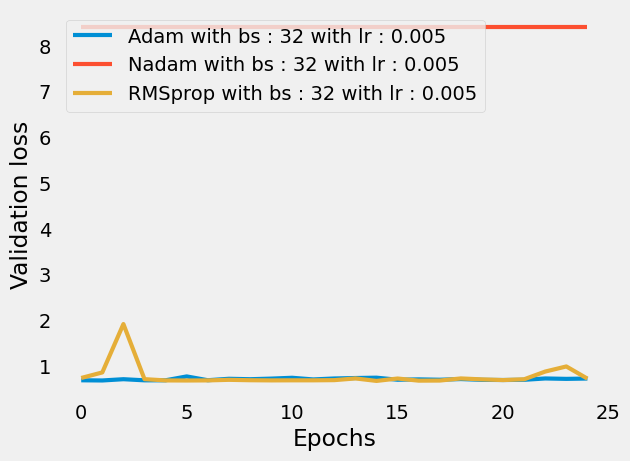

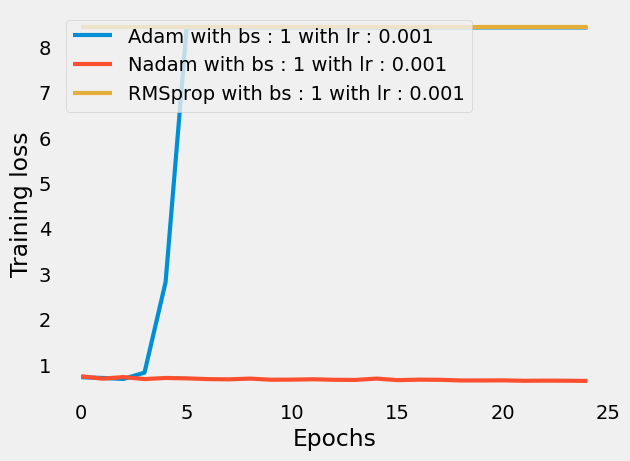

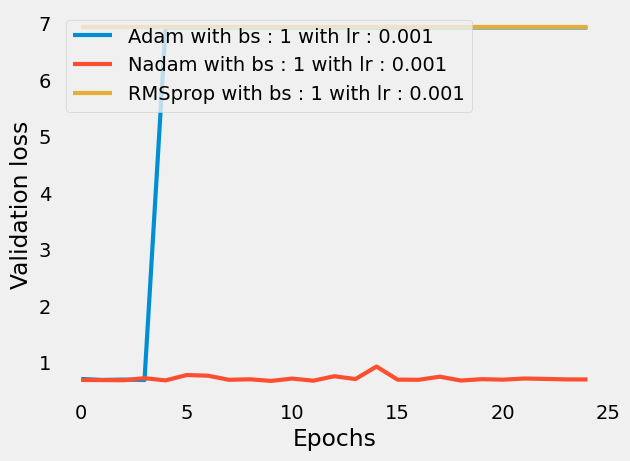

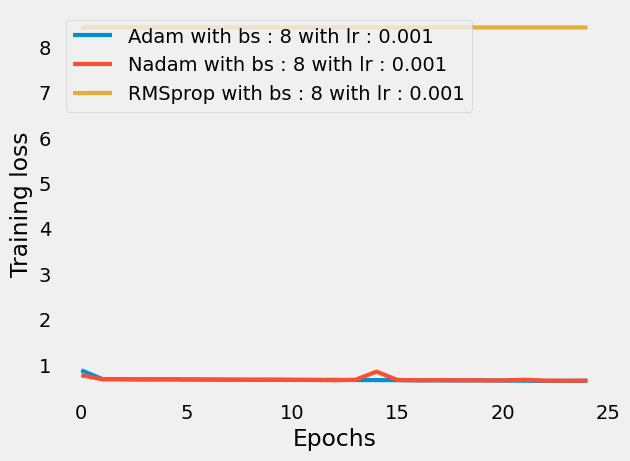

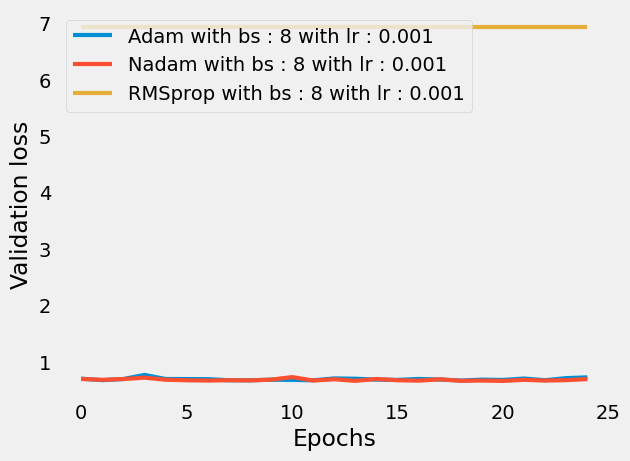

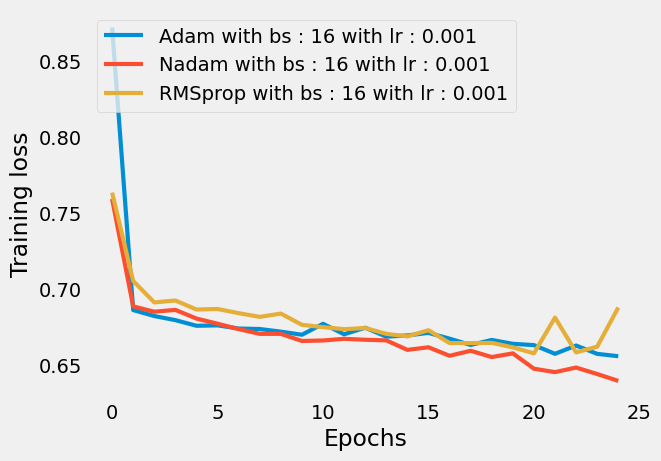

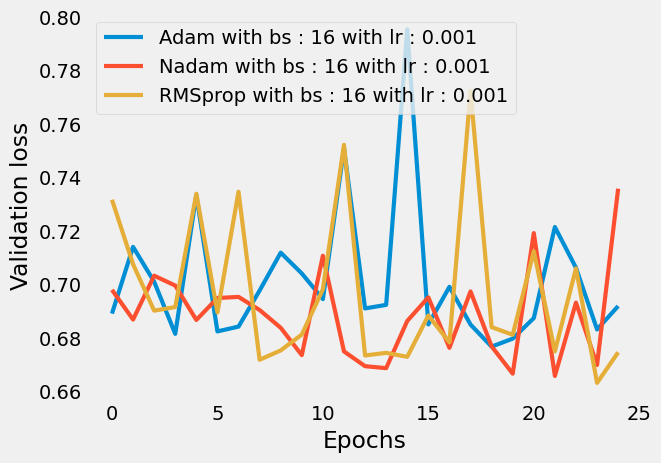

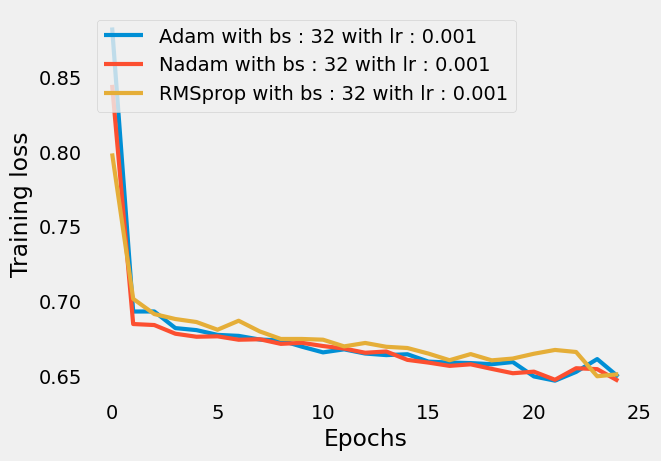

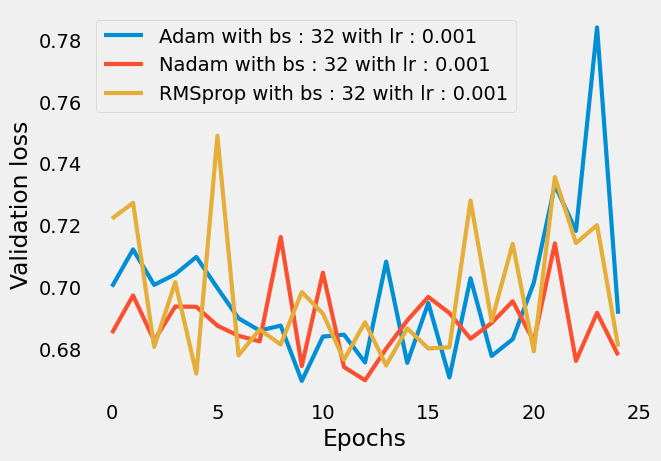

In [631]:
label_pool = []
for lr in learning_rate:
    optimizers = ['Adam', 'Nadam', "RMSprop"]
    for bs in batch_size:
        for epoch in epochs:
            for op in optimizers:
                label_pool.append(str(op) +' with bs : ' +str(bs) + ' with lr : '+ str(lr))
        
for loss in ("loss", "val_loss"):
  for i in range(3):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(3,6):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(6,9):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(9,12):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(12,15):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(15,18):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(18,21):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(21,24):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

## Improvement:
1. the differences between training loss and validation may caused by the over-fitting, so adding a dropout layer may help 
2. Credit to a friend did a similar project before, he suggested us to use same mean and std while scaling the training and testing set

Insights from above tuning:
- 0.001 of learning would perform more stable and better
- batch_size 1 would be too small if we only using 25 epochs
- 3 optimizers perform differently while using different parameter, no correlations could be observed 
- It has a downwards trend of loss if the model works properly, so we should add a little bit more epochs

Next hyper-parameter tuning: 
- learning_rate = [0.001]
- batch_size = [8, 16]
- epochs = [30]

### Model

In [635]:
def multi_branch_lstm_v1(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data, optimizer, batch_size, epoch):
    # Define the inputs for each LSTM branch
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)
    
    input2 = Input(shape=(timesteps, X_train[1].shape[-1]))
    lstm3 = LSTM(units_l1, return_sequences=True)(input2)
    lstm4 = LSTM(units_l2)(lstm3)
    
    input3 = Input(shape=(timesteps, X_train[2].shape[-1]))
    lstm5 = LSTM(units_l1, return_sequences=True)(input3)
    lstm6 = LSTM(units_l2)(lstm5)
    
    input4 = Input(shape=(timesteps, X_train[3].shape[-1]))
    lstm7 = LSTM(units_l1, return_sequences=True)(input4)
    lstm8 = LSTM(units_l2)(lstm7)

    # Concatenate the outputs from each branch
    concat = Concatenate()([lstm2, lstm4, lstm6, lstm8])
    dense1 = Dense(64, activation='relu')(concat)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dense1)
    dropout2 = Dropout(0.2)(dense2)
    output = Dense(1, activation='relu')(dense2)

    # Define the model with multiple inputs and a single output
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    model = model.fit(x=X_train, y=y_train, validation_data=(X_val_dataset, y_val_data), batch_size=batch_size, epochs=epoch)

    return model

### New Scaling

In [636]:
def min_max_with_reshape_v1(df):
    df1 = df[df.index <= '2021-12-31'].copy()
    df_x = df1.iloc[:,1:]
    mean, std = df_x.mean(), df_x.std()
    df_x_value = (df_x - mean) / std
    x_train = df_x_value.values
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    df2 = df[df.index > '2021-12-31'].copy()
    df_y = df2.iloc[:,1:]
    # Using the mean and std of X
    mean, std = df_x.mean(), df_x.std()
    df_y_value = (df_y - mean) / std
    y_train = df_y_value.values
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
    return x_train, y_train


In [637]:
momentum_train, momentum_test = min_max_with_reshape(df_momentum)
print(momentum_train.shape)
volatility_train, volatility_test = min_max_with_reshape(df_volatility)
print(volatility_train.shape)
distance_train, distance_test = min_max_with_reshape(df_distance)
print(distance_train.shape)

(2556, 7, 1)
(2556, 7, 1)
(2556, 7, 1)


In [640]:
timesteps = 7
units_l1 = 64
units_l2 = 32
learning_rate = [0.001]
batch_size = [8, 16]
epochs = [30]
model_pool = []

for lr in learning_rate:
    optimizers = [tf.keras.optimizers.legacy.Adam(lr), tf.keras.optimizers.legacy.Nadam(lr), tf.keras.optimizers.legacy.RMSprop(lr)]
    #optimizers = ['adam', 'SGD']
    for bs in batch_size:
        for epoch in epochs:
            for op in optimizers:
                model_pool.append(multi_branch_lstm_v1(timesteps = timesteps, units_l1=units_l1, units_l2=units_l2
                , X_train = [x_train, momentum_train, volatility_train, distance_train]
                , y_train = y_train.flatten()
                , X_val_dataset=[x_test, momentum_test, volatility_test, distance_test]
                , y_val_data = y_test.flatten(), optimizer = op, batch_size = bs, epoch = 30))
                print(f'learning_rate:{lr}, Optimizer:{op}, batch_size:{bs}, epoch:{epoch}') 

Epoch 1/30
320/320 [==============================] - 11s 14ms/step - loss: 0.7386 - accuracy: 0.5129 - val_loss: 0.7104 - val_accuracy: 0.5041
Epoch 2/30
320/320 [==============================] - 3s 9ms/step - loss: 0.6947 - accuracy: 0.5438 - val_loss: 0.6992 - val_accuracy: 0.4959
Epoch 3/30
320/320 [==============================] - 3s 9ms/step - loss: 0.6924 - accuracy: 0.5391 - val_loss: 0.7235 - val_accuracy: 0.4821
Epoch 4/30
320/320 [==============================] - 3s 9ms/step - loss: 0.6939 - accuracy: 0.5481 - val_loss: 0.6984 - val_accuracy: 0.4904
Epoch 5/30
320/320 [==============================] - 3s 10ms/step - loss: 0.6982 - accuracy: 0.5305 - val_loss: 0.6919 - val_accuracy: 0.5289
Epoch 6/30
320/320 [==============================] - 3s 11ms/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6850 - val_accuracy: 0.5620
Epoch 7/30
320/320 [==============================] - 3s 9ms/step - loss: 0.6851 - accuracy: 0.5567 - val_loss: 0.8682 - val_accuracy: 0.4628
Ep

## Evaluate and compare

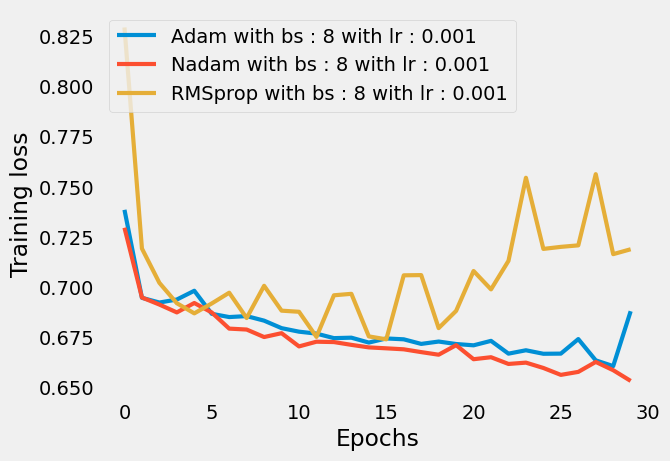

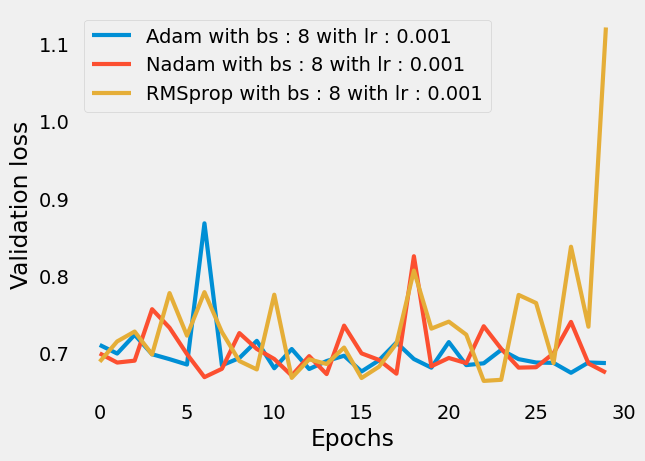

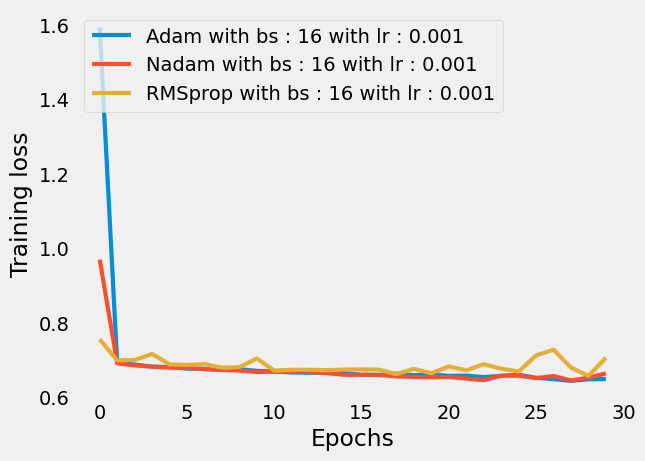

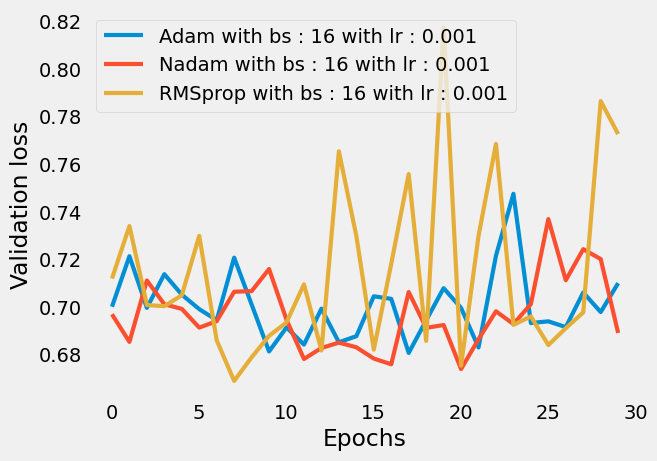

In [643]:
label_pool = []
for lr in learning_rate:
    optimizers = ['Adam', 'Nadam', "RMSprop"]
    for bs in batch_size:
        for epoch in epochs:
            for op in optimizers:
                label_pool.append(str(op) +' with bs : ' +str(bs) + ' with lr : '+ str(lr))
        
for loss in ("loss", "val_loss"):
  for i in range(3):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

for loss in ("loss", "val_loss"):
  for i in range(3,6):
    plt.plot(model_pool[i].history[loss], label=label_pool[i], linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

## Finalize the model 
- RMSprop could reduce the loss quickly, but for a better model, using Nadam and Adam would be better 
- Batch size 8 overperforms 16

In [ ]:
def multi_branch_lstm_v2_history(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data, optimizer, batch_size, epoch):
    # Define the inputs for each LSTM branch
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)
    
    input2 = Input(shape=(timesteps, X_train[1].shape[-1]))
    lstm3 = LSTM(units_l1, return_sequences=True)(input2)
    lstm4 = LSTM(units_l2)(lstm3)
    
    input3 = Input(shape=(timesteps, X_train[2].shape[-1]))
    lstm5 = LSTM(units_l1, return_sequences=True)(input3)
    lstm6 = LSTM(units_l2)(lstm5)
    
    input4 = Input(shape=(timesteps, X_train[3].shape[-1]))
    lstm7 = LSTM(units_l1, return_sequences=True)(input4)
    lstm8 = LSTM(units_l2)(lstm7)

    # Concatenate the outputs from each branch
    concat = Concatenate()([lstm2, lstm4, lstm6, lstm8])
    dense1 = Dense(64, activation='relu')(concat)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dense1)
    dropout2 = Dropout(0.2)(dense2)
    output = Dense(1, activation='relu')(dense2)

    # Define the model with multiple inputs and a single output
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(x=X_train, y=y_train, validation_data=(X_val_dataset, y_val_data), batch_size=batch_size, epochs=epoch)
    score_train = model.evaluate(X_train, y_train, verbose=1)
    score_test = model.evaluate(X_val_dataset, y_val_data, verbose=1)


    return model, score_train, score_test, history

In [ ]:
timesteps = 7
units_l1 = 64
units_l2 = 32
model, score_train, score_test, history = (multi_branch_lstm_v2_history(timesteps = timesteps, units_l1=units_l1, units_l2=units_l2
                , X_train = [x_train, momentum_train, volatility_train, distance_train]
                , y_train = y_train.flatten()
                , X_val_dataset=[x_test, momentum_test, volatility_test, distance_test]
                , y_val_data = y_test.flatten(), optimizer = tf.keras.optimizers.legacy.Adam(0.001), batch_size = 8, epoch = 60))

In [ ]:
print("Train Loss:", score_train[0])
print("Train Accuracy:", score_train[1])

Train Loss: 0.5827707052230835
Train Accuracy: 0.670187771320343


In [ ]:
print("Test Loss:", score_test[0])
print("Test Accuracy:", score_test[1])

Test Loss: 0.9195677042007446
Test Accuracy: 0.5371900796890259


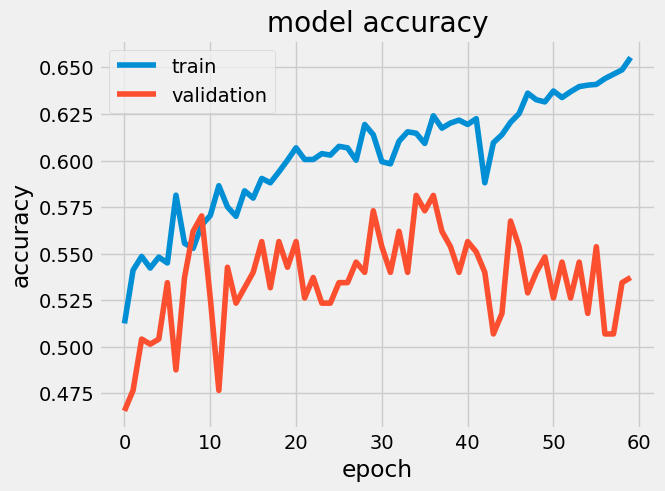

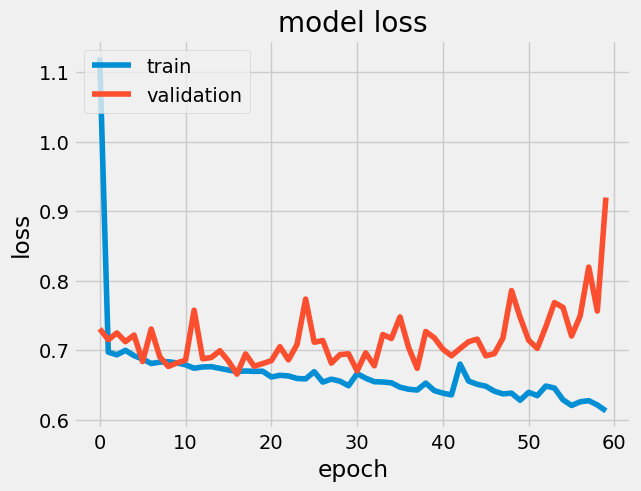

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [650]:
def multi_branch_lstm_v2(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data, optimizer, batch_size, epoch):
    # Define the inputs for each LSTM branch
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)
    
    input2 = Input(shape=(timesteps, X_train[1].shape[-1]))
    lstm3 = LSTM(units_l1, return_sequences=True)(input2)
    lstm4 = LSTM(units_l2)(lstm3)
    
    input3 = Input(shape=(timesteps, X_train[2].shape[-1]))
    lstm5 = LSTM(units_l1, return_sequences=True)(input3)
    lstm6 = LSTM(units_l2)(lstm5)
    
    input4 = Input(shape=(timesteps, X_train[3].shape[-1]))
    lstm7 = LSTM(units_l1, return_sequences=True)(input4)
    lstm8 = LSTM(units_l2)(lstm7)

    # Concatenate the outputs from each branch
    concat = Concatenate()([lstm2, lstm4, lstm6, lstm8])
    dense1 = Dense(64, activation='relu')(concat)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dense1)
    dropout2 = Dropout(0.2)(dense2)
    output = Dense(1, activation='relu')(dense2)

    # Define the model with multiple inputs and a single output
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Train the model
    model.fit(x=X_train, y=y_train, validation_data=(X_val_dataset, y_val_data), batch_size=batch_size, epochs=epoch)

    return model

In [651]:
model = (multi_branch_lstm_v2(timesteps = timesteps, units_l1=units_l1, units_l2=units_l2
                , X_train = [x_train, momentum_train, volatility_train, distance_train]
                , y_train = y_train.flatten()
                , X_val_dataset=[x_test, momentum_test, volatility_test, distance_test]
                , y_val_data = y_test.flatten(), optimizer = tf.keras.optimizers.legacy.Adam(0.001), batch_size = 8, epoch = 60))

Epoch 1/60
320/320 [==============================] - 34s 88ms/step - loss: 0.7795 - accuracy: 0.5113 - val_loss: 0.7450 - val_accuracy: 0.4738
Epoch 2/60
320/320 [==============================] - 23s 72ms/step - loss: 0.6975 - accuracy: 0.5297 - val_loss: 0.7340 - val_accuracy: 0.4959
Epoch 3/60
320/320 [==============================] - 22s 70ms/step - loss: 0.6886 - accuracy: 0.5446 - val_loss: 0.7257 - val_accuracy: 0.5041
Epoch 4/60
320/320 [==============================] - 23s 72ms/step - loss: 0.6956 - accuracy: 0.5387 - val_loss: 0.7393 - val_accuracy: 0.4711
Epoch 5/60
320/320 [==============================] - 22s 67ms/step - loss: 0.6904 - accuracy: 0.5497 - val_loss: 0.6929 - val_accuracy: 0.5152
Epoch 6/60
320/320 [==============================] - 21s 65ms/step - loss: 0.6860 - accuracy: 0.5528 - val_loss: 0.6950 - val_accuracy: 0.5041
Epoch 7/60
320/320 [==============================] - 21s 65ms/step - loss: 0.6824 - accuracy: 0.5524 - val_loss: 0.7453 - val_accuracy:

In [652]:
X_predict = [x_test, momentum_test, volatility_test, distance_test]
predictions = model.predict(X_predict)

12/12 [==============================] - 2s 49ms/step


In [663]:
scaler = MinMaxScaler()
scaler.fit(predictions)
predictions_scaled = scaler.transform(predictions)

In [676]:
prediction_finalized = np.where(predictions_scaled > 0.5, 1, -1)

## Easy Money:
- Using the bot, it would buy before it goes up, and sell before it goes down. In this perfect world below is what we see with logarithmic returns (red) starting from Jan 2022 till Dec 2022. Blue is if you simply invested, and did nothing.
- With our model, it is the time to earn this easy money!

<AxesSubplot: xlabel='Date'>

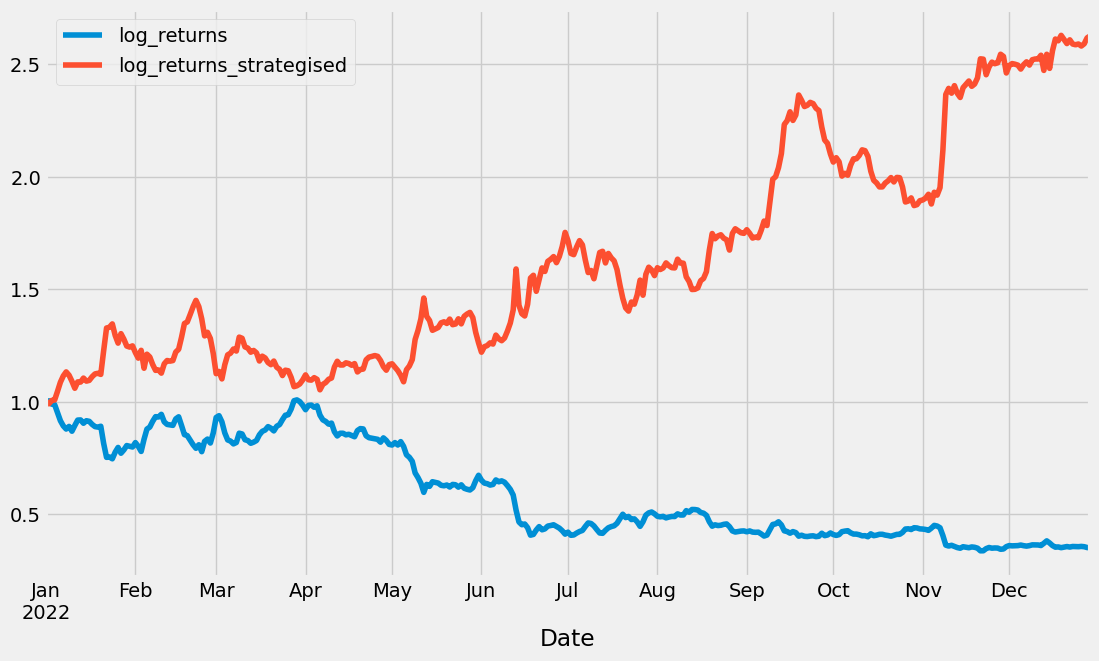

In [677]:
test_data = df[df.index > '2021-12-31'].copy()
test_data = test_data[['log_returns']]
test_data['prediction'] = prediction_finalized
test_data['log_returns_strategised'] = (test_data['prediction'] * test_data['log_returns'])

# 3) Plotting the cum sum to see how effective our model would be
test_data[['log_returns', 'log_returns_strategised']].sum().apply(np.exp)
test_data[['log_returns', 'log_returns_strategised']].cumsum().apply(np.exp).plot(figsize=(12, 7))
